# Initialization

This Notebook is part of the final Thesis.
This consists of analysis, visualisation and parsing of the SQUAD dataset from Json file to Dataframe. 

A simple Question answering system using existing pre-trained model is also illustrated here. 

In [ ]:
# Make sure you have a GPU running
!nvidia-smi

Fri Nov 26 16:42:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import torch
import json
import sys
import time
import datetime
import random
import collections
import pprint
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SQuAD 2.0 Dataset

The SQuAD (Stanford Question and Answering Dataset) is one of the most comprehensive and widely used dataset for Question Answering. It is a hugely popular dataset containing question and answer pairs scraped from Wikipedia, covering topics ranging from Beyonce, to Physics. 

The following steps are followed in this section
1. Define SQUAD URL and Files
2. Write the files in local SQUAD Directory
3. View and analyse Train dataset
4. View and analyse Test dataset


In [ ]:
import os

squad_dir = '/content/drive/MyDrive/FinLitQA/squad'

if not os.path.exists(squad_dir):
    os.mkdir(squad_dir)

In [ ]:
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/'
files = ['train-v2.0.json', 'dev-v2.0.json']

In [ ]:
import requests

for file in files:
    res = requests.get(url+file)
    # write to file in chunks
    with open(os.path.join(squad_dir, file), 'wb') as f:
        for chunk in res.iter_content(chunk_size=40):
            f.write(chunk)

In [ ]:
import json

with open(os.path.join(squad_dir, 'train-v2.0.json'), 'rb') as f:
    squad = json.load(f)

In [ ]:
#squad['data'][0]

In [ ]:
squad['data'][0]['paragraphs'][0]

{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
   'id': '56be85543aeaaa14008c9063',
   'is_impossible': False,
   'question': 'When did Beyonce start becoming popular?'},
  {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
   'id': '56be8554

In [ ]:
#squad['data'][-1]['paragraphs'][0]

### Parse Training dataset
This section includes parsing of the Training dataset. This helps converting the JSON file to Dataframe. 

In [ ]:
# initialize list where we will place all of our data
new_squad = []

# we need to loop through groups -> paragraphs -> qa_pairs
for group in squad['data']:
    for paragraph in group['paragraphs']:
        # we pull out the context from here
        context = paragraph['context']
        for qa_pair in paragraph['qas']:
            # we pull out the question
            question = qa_pair['question']
            # now the logic to check if we have 'answers' or 'plausible_answers'
            if 'answers' in qa_pair.keys() and len(qa_pair['answers']) > 0:
                answer = qa_pair['answers'][0]['text']
            elif 'plausible_answers' in qa_pair.keys() and len(qa_pair['plausible_answers']) > 0:
                answer = qa_pair['plausible_answers'][0]['text']
            else:
                # this shouldn't happen, but just in case we just set answer = None
                answer = None
            # append dictionary sample to parsed squad
            new_squad.append({
                'question': question,
                'answer': answer,
                'context': context
            })

In [ ]:
new_squad[:2], new_squad[-2:]

([{'answer': 'in the late 1990s',
   'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'question': 'When did Beyonce start becoming popular?'},
  {'answer': 'singing and dancing',
   'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and ac

In [ ]:
# Save the parsed training data to json file

with open(os.path.join(squad_dir, 'train.json'), 'w') as f:
    json.dump(new_squad, f)

### Parse Validation Dataset

In this section the same parsing logic is apploed to the validation dataset. 

In [ ]:
squad_dir = '/content/drive/MyDrive/FinLitQA/squad'

In [ ]:
import os
import json

with open(os.path.join(squad_dir, 'dev-v2.0.json'), 'rb') as f:
    squad = json.load(f)

In [ ]:
# Verify structure of validation json file 
squad['data'][0]['paragraphs'][0]

{'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'qas': [{'answers': [{'answer_start': 159, 'text': 'France'},
    {'answer_start': 159, 'text': 'France'},
    {'answer_start': 159, 'text': 'France'},
    {'answer_start': 159, 'text': 'France'}],
   'id': '56ddde6b9a695914005b9628',
   'is

In [ ]:
#squad['data'][-1]['paragraphs'][0]

In [ ]:
# Create a list of dictionaries where each dictionary contains a single question, answer, and context.
# Remove duplicates in the answers lists.

# initialize list where we will place all of our data
new_squad = []

# we need to loop through groups -> paragraphs -> qa_pairs
for group in squad['data']:
    for paragraph in group['paragraphs']:
        # we pull out the context from here
        context = paragraph['context']
        for qa_pair in paragraph['qas']:
            # we pull out the question
            question = qa_pair['question']
            # now the logic to check if we have 'answers' or 'plausible_answers'
            if 'answers' in qa_pair.keys() and len(qa_pair['answers']) > 0:
                answer_list = qa_pair['answers']
            elif 'plausible_answers' in qa_pair.keys() and len(qa_pair['plausible_answers']) > 0:
                answer_list = qa_pair['plausible_answers']
            else:
                # this shouldn't happen, but just in case we just set answer = []
                answer_list = []
            # we want to pull our the 'text' of each answer in our list of answers
            answer_list = [item['text'] for item in answer_list]
            # we can remove duplicate answers by converting our list to a set, and then back to a list
            answer_list = list(set(answer_list))
            # we iterate through each unique answer in the answer_list
            for answer in answer_list:
                # append dictionary sample to parsed squad
                new_squad.append({
                    'question': question,
                    'answer': answer,
                    'context': context
                })

In [ ]:
new_squad[:3], new_squad[-2:]

([{'answer': 'France',
   'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
   'question': 'In what country is Normandy located?'},
  {'answer': 'in the 10th and 11th centuries',
   'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th 

In [ ]:
# Save the parsed validation file to Drive
with open(os.path.join(squad_dir, 'dev.json'), 'w') as f:
    json.dump(new_squad, f)

### Updated Squad Train and Dataset as Dataframes

In [ ]:
with open(os.path.join(squad_dir, 'train.json'), 'rb') as f:
    squad_train = json.load(f)

df_train = pd.DataFrame.from_dict(pd.json_normalize(squad_train), orient='columns')

In [ ]:
df_train.head()

,question,answer,context
0,When did Beyonce start becoming popular?,in the late 1990s,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,What areas did Beyonce compete in when she was...,singing and dancing,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
2,When did Beyonce leave Destiny's Child and bec...,2003,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
3,In what city and state did Beyonce grow up?,"Houston, Texas",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
4,In which decade did Beyonce become famous?,late 1990s,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...


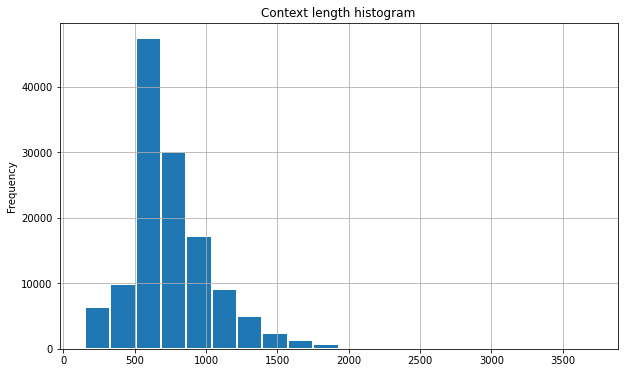

In [ ]:
figsize = (10,6)
df_train['context'].apply(len).plot.hist(title="Context length histogram", bins=20, edgecolor='white', linewidth=2,
                                         figsize=figsize, grid=True)

NameError: ignored

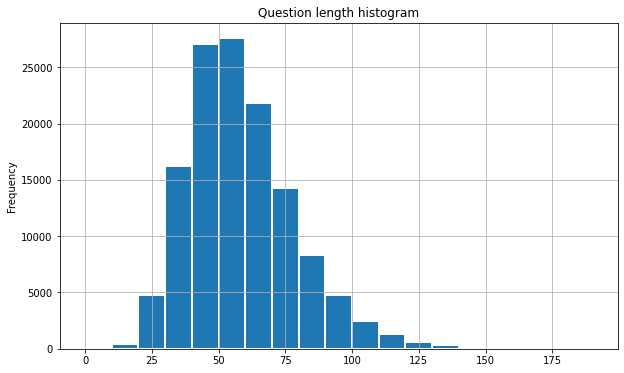

In [ ]:
df_train['question'].apply(len).plot.hist(title="Question length histogram", bins = range(0,200,10), 
                                          edgecolor='white', linewidth=2, figsize=figsize, grid=True)
# bins = np.arange(data.min(), data.max()+.1, 0.1)

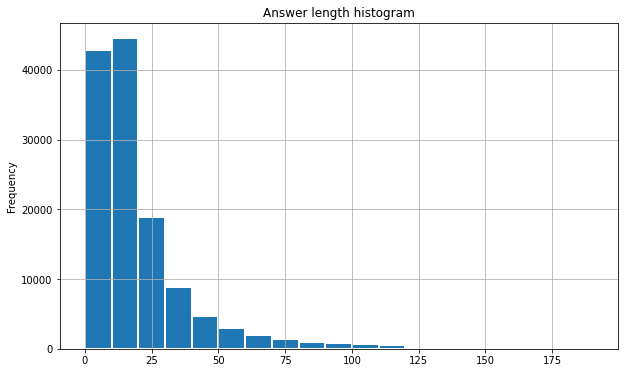

In [ ]:
df_train['answer'].apply(len).plot.hist(title="Answer length histogram", bins= range(0,200,10), 
                                        edgecolor='white', linewidth=2, figsize=figsize, grid=True)

In [ ]:
#@title Show Samples { run: "auto", display-mode: "form" }

sample_index =  22441#@param {type:"slider", min:0, max:62194, step:1}

def print_squad_sample(df: pd.core.frame.DataFrame, line_length: int=10, separator_length: int=100) -> None:
  sample = df.iloc[sample_index]
  # title = sample.title.replace('_', ' ')
  # print('TITLE: ')
  # print(title)
  # print('='*separator_length)
  context = sample.context.split()
  print('CONTEXT: ')
  lines = [' '.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = df[df.context.values==sample.context]
  max_len = len(max(questions.question, key=len)) + 5
  print("{: <{max_len}} {: <{max_len}}".format('QUESTION:','ANSWER:', max_len=max_len))
  for idx, row in questions.iterrows():
    question = row.question
    answer = row.answer
    print("{: <{max_len}} {: <{max_len}}".format(question,answer, max_len=max_len))

print_squad_sample(df_train)

CONTEXT: 
Silicon Alley, centered in Manhattan, has evolved into a metonym
for the sphere encompassing the New York City metropolitan region's
high technology industries involving the Internet, new media, telecommunications, digital
media, software development, biotechnology, game design, financial technology ("fintech"), and
other fields within information technology that are supported by its
entrepreneurship ecosystem and venture capital investments. In the first half
of 2015, Silicon Alley generated over US$3.7 billion in venture
capital investment across a broad spectrum of high technology enterprises,
most based in Manhattan, with others in Brooklyn, Queens, and
elsewhere in the region. High technology startup companies and employment
are growing in New York City and the region, bolstered
by the city's position in North America as the leading
Internet hub and telecommunications center, including its vicinity to several
transatlantic fiber optic trunk lines, New York's intellectual

In [ ]:
with open(os.path.join(squad_dir, 'dev.json'), 'rb') as f:
    squad_dev = json.load(f)

df_dev = pd.DataFrame.from_dict(pd.json_normalize(squad_dev), orient='columns')

In [ ]:
df_dev.head()

,question,answer,context
0,In what country is Normandy located?,France,The Normans (Norman: Nourmands; French: Norman...
1,When were the Normans in Normandy?,in the 10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...
2,When were the Normans in Normandy?,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...
3,From which countries did the Norse originate?,"Denmark, Iceland and Norway",The Normans (Norman: Nourmands; French: Norman...
4,Who was the Norse leader?,Rollo,The Normans (Norman: Nourmands; French: Norman...


### Get the counts for each Question Type

In [ ]:
# Function to get the questions' head
def get_ques_type(question: str) -> str:
    """Extract only the "head" froma a question

    Args:
        question: the question.
    """
    return question.split()[0].strip().lower()


In [ ]:
df_ques_type = df_train.copy()

df_ques_type['question'] = df_ques_type['question'].apply(get_ques_type)

In [ ]:
total = df_ques_type.shape[0]
print (total)
top_qheads = df_ques_type['question'].value_counts().sort_values(ascending=False)[0:25]
qheads = list(top_qheads.index)
count = top_qheads.to_list()

print("Label\t\tCount\t\tPercentage\n")
for i, j in enumerate(top_qheads):
  print("{: <15} {: <15} {:.1f}%".format(qheads[i],j,j/total*100))

130319
Label		Count		Percentage

what            59345           45.5%
who             12536           9.6%
how             11631           8.9%
when            7871            6.0%
in              6539            5.0%
which           5721            4.4%
where           4727            3.6%
the             3138            2.4%
why             1866            1.4%
on              779             0.6%
along           697             0.5%
during          631             0.5%
at              433             0.3%
a               420             0.3%
for             396             0.3%
according       365             0.3%
from            361             0.3%
to              356             0.3%
by              355             0.3%
whose           331             0.3%
after           317             0.2%
what's          248             0.2%
with            224             0.2%
besides         221             0.2%
is              219             0.2%


In [ ]:
print (qheads)

['what', 'who', 'how', 'when', 'in', 'which', 'where', 'the', 'why', 'on', 'along', 'during', 'at', 'a', 'for', 'according', 'from', 'to', 'by', 'whose', 'after', "what's", 'with', 'besides', 'is']


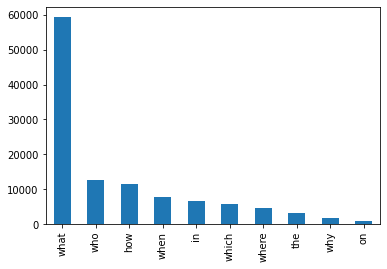

In [ ]:
df_ques_type['question'].value_counts().sort_values(ascending=False)[0:10].plot.bar()

# Visualize Question Answering

In this section, an existing pre-trained Transformer model is used to Visualise the working of a Question Answering system. The model used is "bert-large-uncased-whole-word-masking-finetuned-squad". 



In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 57.0 MB/s 
     |████████████████████████████████| 3.3 MB 68.7 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
     |████████████████████████████████| 59 kB 9.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments, \
BertForQuestionAnswering, DistilBertForTokenClassification, AutoTokenizer, AutoModel, AutoModelForTokenClassification

import torch
from transformers import pipeline
import numpy as np
import pandas as pd
from transformers import DistilBertForTokenClassification


# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Common Functions: 

def question_answer(question, text, model, tokenizer):
    
    #tokenize question and text in ids as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    #number of tokens in segment A - question
    num_seg_a = sep_idx+1

    #number of tokens in segment B - text
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    
#   print("Text:\n{}".format(text.capitalize()))
#   print("\nQuestion:\n{}".format(question.capitalize()))
    print("\nAnswer:\n{}".format(answer.capitalize()))

    return output, tokens

# Function to visualize the scores
def plot_scores(x_data, y_data, data_title):
  plt.rcParams["figure.figsize"] = (20,6)
  ax = sns.barplot(x_data, y_data, ci=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
  ax.grid(True)
  plt.title(data_title)
  plt.show()

In [ ]:
# Define the model for Question answering
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
# Get random question and answer:
random_num = np.random.randint(0,len(df_train))

question = df_train["question"][random_num]
text = df_train["context"][random_num]
print(question, "\n", text)

When was the first documented translation efforts by foreign Buddhist monks in China? 
 The Silk Road transmission of Buddhism to China is most commonly thought to have started in the late 2nd or the 1st century CE, though the literary sources are all open to question.[note 41] The first documented translation efforts by foreign Buddhist monks in China were in the 2nd century CE, probably as a consequence of the expansion of the Kushan Empire into the Chinese territory of the Tarim Basin.


In [ ]:
# Call the Question Answer function

output, tokens = question_answer(question, text, model, tokenizer)
print("Original answer:\n", df_train.loc[df_train["question"] == question]["answer"].values[0])


Answer:
2nd century ce
Original answer:
 2nd century CE


In [ ]:
start_scores = output.start_logits.detach().numpy().flatten()
end_scores = output.end_logits.detach().numpy().flatten()

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

print(len(token_labels))

96


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


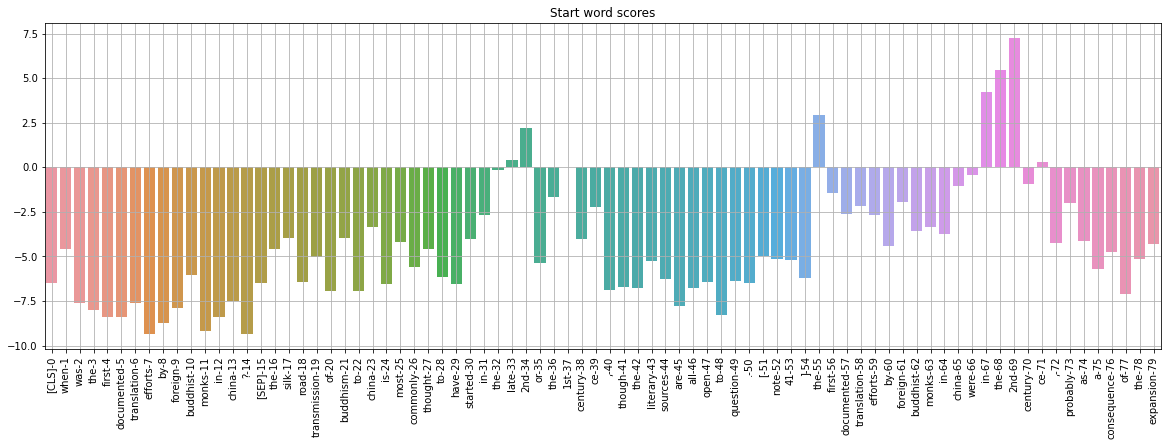

In [ ]:
plot_scores (token_labels[:80], start_scores[:80], "Start word scores")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


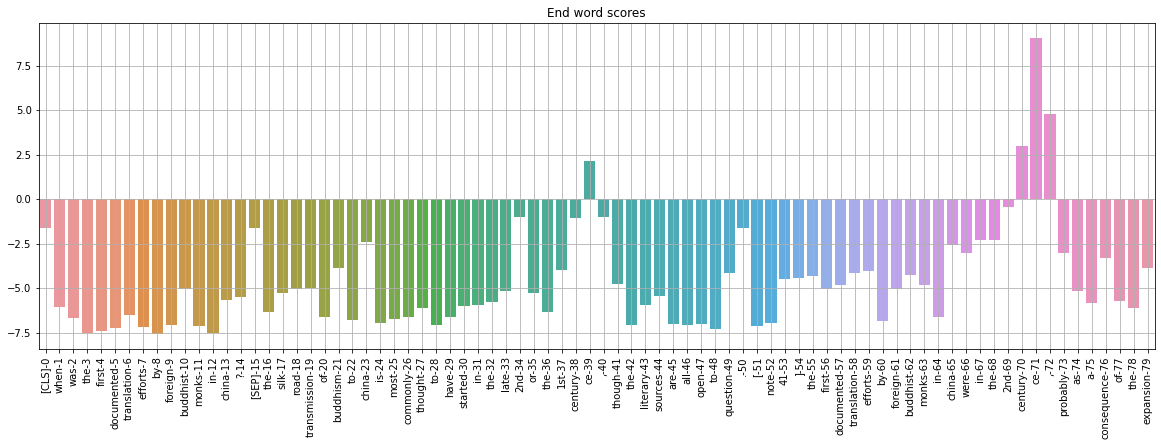

In [ ]:
plot_scores (token_labels[:80], end_scores[:80], "End word scores")

# SQUAD dataset analysis using transformer load_dataset

In [ ]:
!pip install datasets

     |████████████████████████████████| 290 kB 5.0 MB/s 
     |████████████████████████████████| 132 kB 71.5 MB/s 
     |████████████████████████████████| 1.1 MB 51.3 MB/s 
     |████████████████████████████████| 243 kB 73.6 MB/s 
     |████████████████████████████████| 160 kB 70.6 MB/s 
     |████████████████████████████████| 192 kB 74.6 MB/s 
     |████████████████████████████████| 271 kB 69.5 MB/s 


In [ ]:
import transformers
import datasets
from datasets import load_dataset

In [ ]:
# Load Squad v1 dataset
squad1_ds = load_dataset('squad')
print(squad1_ds)

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


In [ ]:
# Load Squad v2 dataset

squad_ds = load_dataset('squad_v2')
print(squad_ds)

Reusing dataset squad_v2 (/root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


In [ ]:
# Note that there is only one possible answer per examples in the training set 
# (i.e. answers.answer_start has one element), but multiple possible answers in the validation set:
# To get the frequencies of possible answers for questions

answers_ds = squad_ds.map(lambda x : {'num_possible_answers' : pd.Series(x['answers']['answer_start']).nunique()})
answers_ds.set_format('pandas')
answers_df = answers_ds['validation'][:]
answers_df['num_possible_answers'].value_counts()

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-6a494185a6979eec.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d/cache-f94d37b0b72fb0d4.arrow


0    5945
1    3500
2    1885
3     471
4      65
5       7
Name: num_possible_answers, dtype: int64

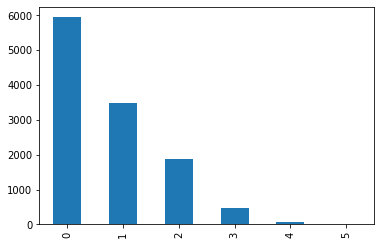

In [ ]:
answers_df['num_possible_answers'].value_counts().transpose().plot.bar()

In [ ]:
# squad v1 for comparison
#Note that there is only one possible answer per examples in the training set 
# (i.e. answers.answer_start has one element), but multiple possible answers in the validation set:
# To get the frequencies of possible answers for questions

answers_ds = squad1_ds.map(lambda x : {'num_possible_answers' : pd.Series(x['answers']['answer_start']).nunique()})
answers_ds.set_format('pandas')
answers_df = answers_ds['validation'][:]
answers_df['num_possible_answers'].value_counts()

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-46f9850aa9f85fc3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-55969edacd204b80.arrow


1    6238
2    3498
3     754
4      71
5       9
Name: num_possible_answers, dtype: int64

In [ ]:
squad_ds['train']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})

In [ ]:
squad_ds.set_format("pandas")
# Flatten the nested dataset columns for easy access
dfs = {split:ds[:] for split, ds in squad_ds.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 130319
Number of questions in validation: 11873


In [ ]:
dfs["train"].columns, dfs["validation"].columns

(Index(['id', 'title', 'context', 'question', 'answers.text',
       'answers.answer_start'],
      dtype='object'), Index(['id', 'title', 'context', 'question', 'answers.text',
       'answers.answer_start'],
      dtype='object'))

In [ ]:
dfs["train"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    130319 non-null  object
 1   title                 130319 non-null  object
 2   context               130319 non-null  object
 3   question              130319 non-null  object
 4   answers.text          130319 non-null  object
 5   answers.answer_start  130319 non-null  object
dtypes: object(6)
memory usage: 6.0+ MB


In [ ]:
qa_cols = ["id", "title", "context", "question", "answers.text",	"answers.answer_start"]
           
sample_df = dfs["train"][qa_cols].sample(5, random_state=7)

In [ ]:
sample_df

,id,title,context,question,answers.text,answers.answer_start
91247,5729315c3f37b319004780d5,Race_(human_categorization),Kaszycka et al. (2009) in 2002–2003 surveyed E...,What are views on race highly dependent on?,[education],[598]
39222,570cdd7cb3d812140066d2d1,Mary_(mother_of_Jesus),"Mary resided in ""her own house""[Lk.1:56] in Na...","In his dream, who told Joseph about Mary's con...",[an angel of the Lord],[469]
26425,56f980059e9bad19000a09dc,Ministry_of_Defence_(United_Kingdom),The defence estate is divided as training area...,Who manages the defence estate?,[Defence Infrastructure Organisation],[223]
99242,5a57ce27770dc0001aeefd99,Empiricism,"A generation later, the Irish Anglican bishop,...",What was Locke's religion?,[],[]
72439,5a7376ae53a187001ae631f0,Comcast,"Critics noted in 2013 that Tom Wheeler, the he...",When was Tom Wheeler the head of the CTIA?,[],[]


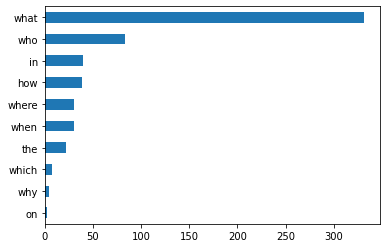

In [ ]:
import pandas as pd
counts = {}
question_types = ['what', 'who', 'how', 'when', 'in', 'which', 'where', 'the', 'why', 'on']

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh();

In [ ]:
for question_type in ["what","who", "in", "how", "when"]:
    for question in (dfs["train"]
                     .query(f"question.str.startswith('{question_type}')", engine='python')
                     .sample(n=3, random_state=42)['question']):
        print(question)
    print()

what is it called when fiber-optics are used for end users?
what is reflected and transmitted into the ground when a plane surface is struck?
what producer was the first to produce deep house? 

who was a pioneer of the genre in america?
who talked about Beyonce's tone and timbre as distinctive?
who founded KMS Records?

in 1778 most of the troops that the EIC had were from where?
in what year did the Seven years' war
in 1720 what % of  import goods were from India? 

how long does the engraved have from start to finish? 
how many men's volleyball NCAA Division III championships have they won?
how many square kilometres  is the island?

when was the height of mosaic art in sicily?
when did ranchers usually have a cattle round up?
when EIC become more like a regularised subsidiary  did they have greater or less accountability to the Crown



# SQUAD to Dataframe


In [ ]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
import numpy as np 
import pandas as pd
import json

In [ ]:
# training data
input_file_path = '/content/drive/MyDrive/FinLitQA/squad/train-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
train = squad_json_to_dataframe_train(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


shape of the dataframe is (130319, 6)
Done


In [ ]:
train.head()

,index,question,context,text,answer_start,c_id
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269.0,0
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207.0,0
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526.0,0
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166.0,0
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276.0,0


In [ ]:
# dev data
input_file_path = '/content/drive/MyDrive/FinLitQA/squad/dev-v2.0.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


shape of the dataframe is (11873, 5)
Done


In [ ]:
dev.head()

,id,question,context,answers,c_id
0,56ddde6b9a695914005b9628,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,"[{'text': 'France', 'answer_start': 159}, {'te...",0
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,"[{'text': '10th and 11th centuries', 'answer_s...",0
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,"[{'text': 'Denmark, Iceland and Norway', 'answ...",0
3,56ddde6b9a695914005b962b,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,"[{'text': 'Rollo', 'answer_start': 308}, {'tex...",0
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,"[{'text': '10th century', 'answer_start': 671}...",0


# Split squad and create sample_squad dataset



In [ ]:
num_train_examples = 10000
num_eval_examples = 100

# train samples
train_examples = dataset['train'].shuffle(seed=seed).select(range(num_train_examples))

# evaluation samples
eval_examples = dataset['validation'].shuffle(seed=seed).select(range(num_eval_examples))

NameError: ignored

In [ ]:
import os
import json
#you need to add you path here
with open(os.path.join('C:/Users/Acer/Desktop/New folder', 'twitter_data.json'), 'r',
          encoding='utf-8') as f1:
    ll = [json.loads(line.strip()) for line in f1.readlines()]

    #this is the total length size of the json file
    print(len(ll))

    #in here 2000 means we getting splits of 2000 tweets
    #you can define your own size of split according to your need
    size_of_the_split=2000
    total = len(ll) // size_of_the_split

    #in here you will get the Number of splits
    print(total+1)

    for i in range(total+1):
        json.dump(ll[i * size_of_the_split:(i + 1) * size_of_the_split], open(
            "C:/Users/Acer/Desktop/New folder/twitter_data_split" + str(i+1) + ".json", 'w',
            encoding='utf8'), ensure_ascii=False, indent=True)